## Relax Challenge

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold 
#import sklearn.metrics.roc_curve
%matplotlib inline

### Load the data set

In [78]:
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
engagement = pd.read_csv("takehome_user_engagement.csv",encoding = "ISO-8859-1")

In [79]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [80]:
engagement.sample(5)

,time_stamp,user_id,visited
32910,3/21/14 20:39,2013,1
79305,6/4/13 1:14,4421,1
3378,4/6/13 12:41,200,1
98715,9/25/13 8:02,5386,1
149761,12/15/13 15:45,8615,1


### Convert the timestamp to datetime type.

In [81]:
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [82]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:00,1,1
1,2013-11-15 03:45:00,2,1
2,2013-11-29 03:45:00,2,1
3,2013-12-09 03:45:00,2,1
4,2013-12-25 03:45:00,2,1


### Create derived temporal features

In [83]:
engagement['month'] = engagement.time_stamp.dt.month
engagement['hour'] = engagement.time_stamp.dt.hour
engagement['day'] = engagement.time_stamp.dt.dayofweek

#### Create a group by aggregate by month, hour and day of the week

In [84]:
engagement_grp_month = engagement.groupby(['user_id','month']).count().reset_index()
engagement_grp_month=engagement_grp_month.drop(['hour','time_stamp','day'],axis=1)

engagement_grp_hour = engagement.groupby(['user_id','hour']).count().reset_index()
engagement_grp_hour = engagement_grp_hour.drop(['month','time_stamp','day'],axis=1)

engagement_grp_day = engagement.groupby(['user_id','day']).count().reset_index()
engagement_grp_day = engagement_grp_day.drop(['month','time_stamp','hour'],axis=1)

In [85]:
engagement_grp_day.day = engagement_grp_day.day.astype('str')
engagement_grp_day.day = engagement_grp_day.day.map({ '0':'Monday', '1': 'Tuesday',
                                      '2': 'Wednesday', '3':'Thursday', '4': 'Friday', '5':'Saturday','6':'Sunday'})

In [86]:
engagement_grp_month.month = engagement_grp_month.month.astype('str')
engagement_grp_month.month = engagement_grp_month.month.map({'1':'Jan', '2':'Feb', '3':'Mar', '4':'Apr', '5':'May',
                                                    '6':'Jun','7':'Jul','8':'Aug','9':'Sept','10':'Oct','11':'Nov',
                                                    '12':'Dec'})

#### Sample group by month features

In [87]:
engagement_grp_month.sample(5)

,user_id,month,visited
17604,9742,Jun,3
12002,6633,Apr,21
9439,5170,Feb,1
11107,6108,Mar,2
11416,6266,Jul,12


#### Sample group by hour features

In [88]:
engagement_grp_hour.sample(5)

,user_id,hour,visited
1943,2669,21,1
7722,10490,9,1
6101,8349,1,1
7932,10782,11,1
1251,1720,16,5


In [89]:
engagement_grp_hour

,user_id,hour,visited
0,1,3,1
1,2,3,14
2,3,23,1
3,4,8,1
4,5,10,1
...,...,...,...
8818,11996,6,1
8819,11997,18,1
8820,11998,12,1
8821,11999,11,1


#### Sample group by day features

In [90]:
engagement_grp_day.sample(5)

,user_id,day,visited
13281,8157,Tuesday,1
5030,3080,Monday,2
3741,2312,Monday,10
9839,6004,Thursday,1
3543,2196,Wednesday,1


#### Transform the group by aggregate by pivoting it on day

In [91]:
engagement_grp_day=engagement_grp_day.pivot(index='user_id',columns='day',values='visited').fillna(0)
engagement_grp_day['day_average']=np.average(engagement_grp_day[:],axis=1)
engagement_grp_day['day_max']=np.max(engagement_grp_day[:],axis=1)
engagement_grp_day = engagement_grp_day.astype('int32')

In [92]:
engagement_grp_day.sample(5)

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,day_average,day_max
user_id,,,,,,,,,
1369,0,0,0,0,0,0,1,0,1
5624,0,0,0,0,0,0,1,0,1
9210,1,1,2,1,0,1,0,0,2
8850,0,0,0,0,0,1,0,0,1
3807,0,0,0,1,0,0,0,0,1


#### Transform the group by aggregate by pivoting it on month

In [16]:
engagement_grp_month = engagement_grp_month.pivot (index='user_id', columns='month', values='visited').fillna(0)
engagement_grp_month['month_average'] =  np.average(engagement_grp_month[:],axis=1)
engagement_grp_month['montly_max'] =  np.max(engagement_grp_month[:],axis=1)
engagement_grp_month = engagement_grp_month.astype('int32')
engagement_grp_month.sample(5)

month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sept,month_average,montly_max
user_id,,,,,,,,,,,,,,
1317,0,0,0,0,1,0,0,0,0,0,0,0,0,1
8649,1,0,0,0,0,0,0,0,0,0,0,0,0,1
6190,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3460,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3324,4,0,0,0,0,0,2,1,7,0,0,0,1,7


#### Transform the group by aggregate by pivoting it on hour

In [17]:
engagement_grp_hour = engagement_grp_hour.pivot(index='user_id', columns='hour', values='visited').fillna(0)
engagement_grp_hour['hourly_max'] = np.max(engagement_grp_hour[:],axis=1)
engagement_grp_hour['hourly_average'] = np.average(engagement_grp_hour[:],axis=1)
engagement_grp_hour = engagement_grp_hour.astype('int32')
engagement_grp_hour.sample(5)

hour,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,hourly_max,hourly_average
user_id,,,,,,,,,,,,,,,,,,,,,
7238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1416,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2905,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Join all the group by aggregate

In [18]:
engagement_final=engagement_grp_month.join(engagement_grp_day).\
                join(engagement_grp_hour).reset_index()

In [19]:
engagement_final.sample(5)

,user_id,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,...,16,17,18,19,20,21,22,23,hourly_max,hourly_average
5797,7955,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
6072,8312,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
7581,10309,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5850,8031,20,11,10,17,18,12,15,17,20,...,0,0,0,0,0,0,0,0,178,14
2405,3280,0,0,0,0,0,0,1,0,4,...,0,0,0,0,0,0,0,0,5,0


In [20]:
engagement_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 50 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         8823 non-null   int64
 1   Apr             8823 non-null   int32
 2   Aug             8823 non-null   int32
 3   Dec             8823 non-null   int32
 4   Feb             8823 non-null   int32
 5   Jan             8823 non-null   int32
 6   Jul             8823 non-null   int32
 7   Jun             8823 non-null   int32
 8   Mar             8823 non-null   int32
 9   May             8823 non-null   int32
 10  Nov             8823 non-null   int32
 11  Oct             8823 non-null   int32
 12  Sept            8823 non-null   int32
 13  month_average   8823 non-null   int32
 14  montly_max      8823 non-null   int32
 15  Friday          8823 non-null   int32
 16  Monday          8823 non-null   int32
 17  Saturday        8823 non-null   int32
 18  Sunday          8823 non-nul

### Find "adopted" Users

In [21]:
df = pd.read_csv("takehome_user_engagement.csv",encoding = "ISO-8859-1")

In [22]:
df.time_stamp = pd.to_datetime(df.time_stamp)
df['week_hour'] = df.time_stamp.dt.strftime('%U-%Y')

In [23]:
df_group = df.groupby(['user_id','week_hour']).size().reset_index().rename(columns={0:'counter'})

In [24]:
df_group['adopted']=df_group.counter>2
adopted_users=df_group.user_id[df_group.adopted == True]
adopted_users=adopted_users.unique()

In [25]:
engagement_final['adopted'] = 0
engagement_final.adopted=engagement_final.user_id.apply(lambda x: 1 if x in adopted_users else 0)

In [26]:
 engagement_final.sample(5)

,user_id,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,...,17,18,19,20,21,22,23,hourly_max,hourly_average,adopted
830,1152,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
794,1106,2,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,0,9,0,1
3099,4217,24,15,13,24,17,4,7,31,30,...,0,0,0,0,0,0,0,222,17,1
4963,6794,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5586,7651,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Get User's attributes

In [27]:
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")

In [28]:
users=users.drop(['name','email','last_session_creation_time','creation_time'],axis=1)

In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   invited_by_user_id          6417 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


In [30]:
users.sample(5)

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
10288,10289,PERSONAL_PROJECTS,0,0,0,NaN
10196,10197,PERSONAL_PROJECTS,0,0,316,NaN
2808,2809,SIGNUP,0,0,16,NaN
1780,1781,GUEST_INVITE,1,0,9,6442.0
3251,3252,SIGNUP,0,0,305,NaN


In [31]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0).astype(int)

In [32]:
users['invited_user_adopted'] = users.invited_by_user_id.apply( lambda x:  x in adopted_users)
users = users.drop(['invited_by_user_id'],axis=1)

In [33]:
users.org_id = users.org_id.astype('str')
users.invited_user_adopted = users.invited_user_adopted.astype('str')
users.org_id = users.org_id.apply(lambda x: 1234 if x == 0 else x)
users = pd.get_dummies(users)
users = users.rename(columns={'object_id':'user_id'})
users.shape

(12000, 427)

#### Adopted users dataframe

In [34]:
users.head(5)

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,...,org_id_92,org_id_93,org_id_94,org_id_95,org_id_96,org_id_97,org_id_98,org_id_99,invited_user_adopted_False,invited_user_adopted_True
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Merge users  with engagment dataframe to create final dataframe

In [35]:
df = pd.merge(users,engagement_final,on='user_id', how='outer')
df = df.reset_index()
df=df.fillna(0).astype(int)

In [36]:
df.sample(5)

,index,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,17,18,19,20,21,22,23,hourly_max,hourly_average,adopted
11085,11085,11086,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,14,1,0
1390,1390,1391,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1111,1111,1112,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3909,3909,3910,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,196,197,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,205,16,1


#### Imbalance Dataset 

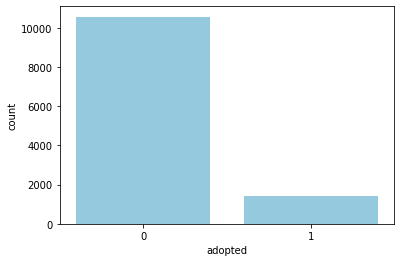

In [37]:
sb.countplot(df.adopted,color='skyblue')

In [38]:
y=df['adopted']

In [39]:
X=df.drop(['adopted'],axis=1)

In [40]:
X.head(5)

,index,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,16,17,18,19,20,21,22,23,hourly_max,hourly_average
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,14,1
2,2,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,3,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,5,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Train an basic model with single split of imbalance data

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [53]:
rcf = RandomForestClassifier(n_estimators=1000)
rcf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
y_predict = rcf.predict(X_test)

##### Using F1 score as the performance metrics, seems to be overfitted or imbalance data is creating a bias

In [44]:
f1_score(y_predict,y_test)

0.9584569732937686

#### Feature importance

In [55]:
feat_importances = pd.Series(rcf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head()

day_average       0.074337
hourly_max        0.067387
montly_max        0.065917
hourly_average    0.064342
day_max           0.060724
dtype: float64

#### Using Stratified kfold for cross validation and handling both the classes equally

In [58]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [59]:
skf.get_n_splits(X, y)

10

In [60]:

best = 0
best_model = None
for train_index, test_index in skf.split(X, y):
    X.shape
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rcf = RandomForestClassifier(n_estimators=500 )
    rcf.fit(X_train, y_train)
    y_predict = rcf.predict(X_test)
    score = f1_score(y_predict,y_test)
    print(score)
    if score > best:
        best = score
        best_model = rcf

In [61]:
best

0.965034965034965

In [62]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head()

hourly_max        0.077888
montly_max        0.076752
day_average       0.072758
hourly_average    0.071622
month_average     0.065895
dtype: float64

### Conclusion:

The results prove that user who login more frequently is more likely to be adopted. 